In [1]:
using PyPlot
using QuantumOptics
using DifferentialEquations
using Statistics, Distributions, Random
using FFTW
using Interpolations
using PhysicalConstants.CODATA2018: c_0, k_B, m_u
using Unitful

using DataFrames
using CSV

#### Rydberg excitation simulator

__Features:__


- simulation of atom dynamics in dipole trap


- laser phase noise generation with given spectral density


- finite contrast of oscillations

### 4-level system + spontaneous emission

Atom can make spontaneous transition from intermediate state $\left| p\right> $ to ground state $\left|g\right>$ or other non-computational ground states $\left| g'\right>$.


__Finite-contrast errors:__

$\eta$ - finite efficiency of state preparation. Probability that after state preparation atom is not in $\left|g\right>$.

$\varepsilon = P(r|g)$ - false positives error in Rydberg detection. Probability to incorrectly infer that a ground-state atom was in $\left|r\right>$ because it was lost due to background collisions.

$\varepsilon' = P(g|r)$ - false negatives error in Rydberg detection. Rydberg atom that quickly decayed back to ground-state is recaptured.


In Browayes article $(\varepsilon, \varepsilon', \eta) = (0.02, 0.05, 0.005)$


__Correspondence with Julia code:__


- $\left| g\right> = \left| 1 \right>$

- $\left| p\right> = \left| 2 \right>$

- $\left| r\right> = \left| 3 \right>$

- $\left| g'\right> = \left| 4 \right>$

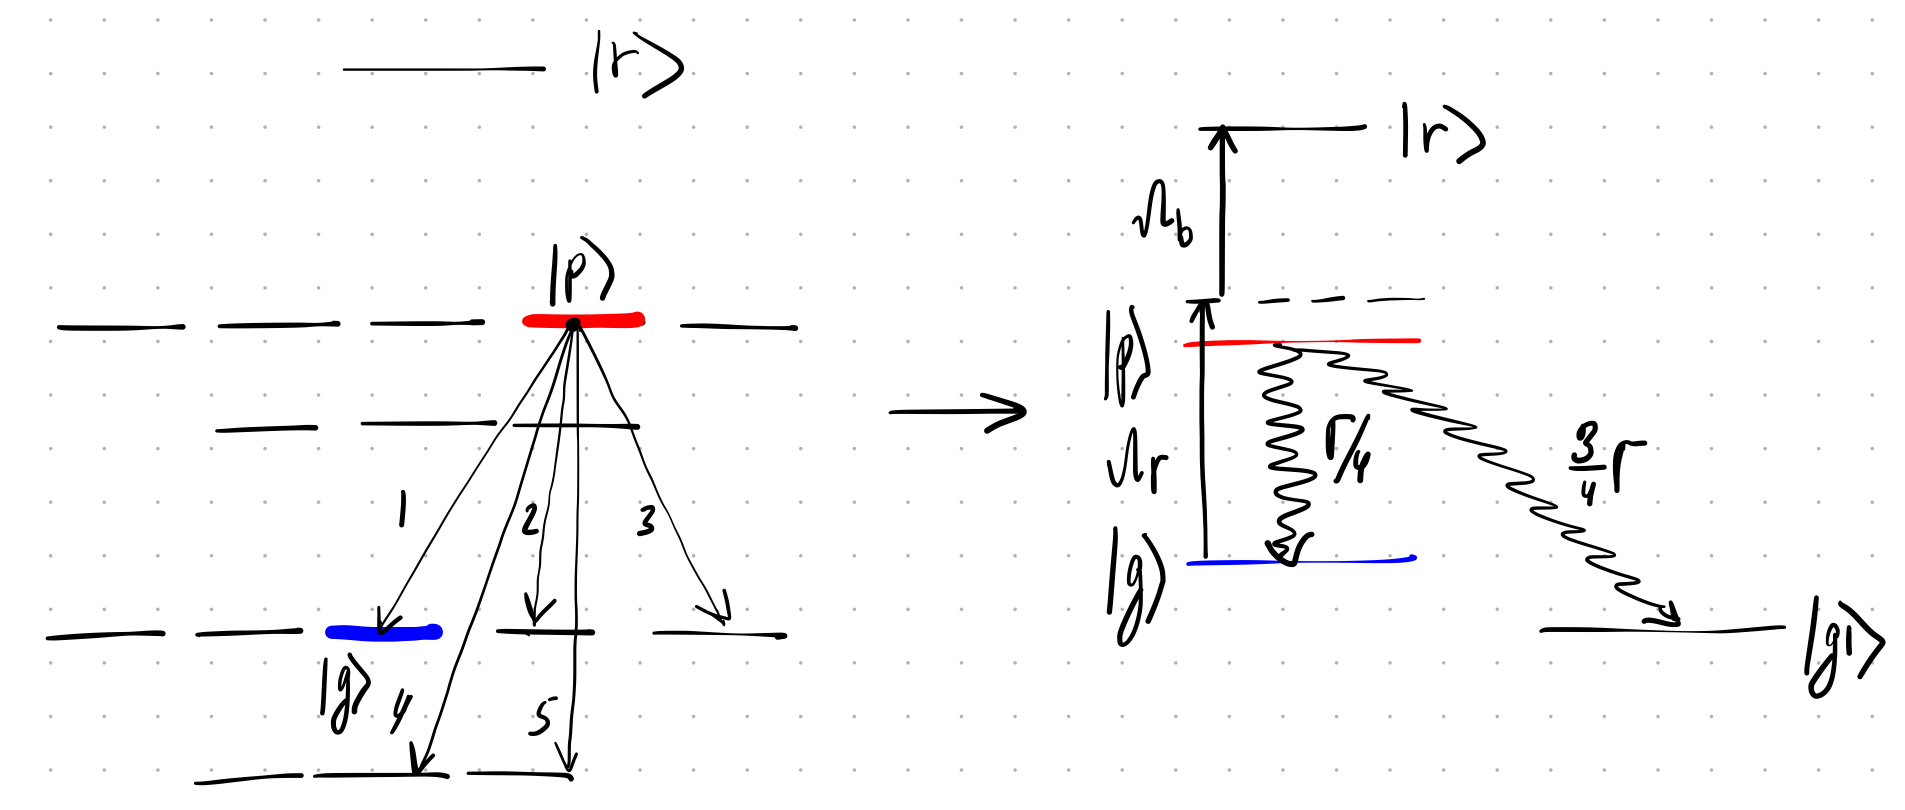

In [7]:
b = NLevelBasis(4);
g = nlevelstate(b, 1);
p = nlevelstate(b, 2);
r = nlevelstate(b, 3);
g_trash = nlevelstate(b, 4);

In [8]:
Ωb = 2π * 47;
Ωr = 2π * 47;
Δ = 2π * 900;
δ = (Ωb^2 - Ωr^2)/(4*Δ);
Γ = 2π * 6;
Γg = 1/4 * Γ;
Γg_trash = 3/4 * Γ;

eps, eps_tick, eta = 0.05, 0.08, 0.03

Jg = sqrt(Γg)* g ⊗ dagger(p);
Jg_trash = sqrt(Γg_trash)* g_trash ⊗ dagger(p);
J = [Jg, Jg_trash];

H = Ωr/2 * (g ⊗ dagger(p) + p ⊗ dagger(g)) + 
    Ωb/2 * (p ⊗ dagger(r) + r ⊗ dagger(p)) -
    Δ * p ⊗ dagger(p) - δ * r ⊗ dagger(r);

In [9]:
T = [0:0.01:5;];
ψ0 = nlevelstate(b, 1);
ρ0 = ψ0 ⊗ dagger(ψ0);

tots, ρ = timeevolution.master(T, ρ0, H, J; alg=Rosenbrock23(autodiff=false));

Pg_tilde = expect(g ⊗ dagger(g), ρ);
Pr_tilde = expect(r ⊗ dagger(r), ρ);

In [10]:
eps, eps_tick, eta = 0.02, 0.05, 0.005

Pg = eta*(1-eps) .+ (1-eta)*(1-eps).*(Pg_tilde .+ eps_tick*Pr_tilde);
Pr = eta*eps .+ (1-eta)*(eps*Pg_tilde .+ (1-eps_tick .+ eps*eps_tick)*Pr_tilde);

In [11]:
figure(figsize=(12,4))
plot(T, Pr_tilde, linewidth=2, color="orangered", label="True", linestyle="--");
plot(T, Pr, linewidth=2, color="blue", label="Finite contrast")
xlabel("Time, μs", fontsize=14)
ylabel("ρᵣᵣ", fontsize=14)
ylim(0.0,1.0)
xlim(0.0,4.0)
title("Ω = 2π × 1.2 MHz")
legend()

/Users/goloshch/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/goloshch/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


PyObject <matplotlib.legend.Legend object at 0x138fdaa40>

### Comparison of $m_F=2$ with $m_F=0$ damping due to radiative decay from intermediate state

In [12]:
N = 4
b = NLevelBasis(N);

g = nlevelstate(b, 1);
p = nlevelstate(b, 2);
r = nlevelstate(b, 3);
g_trash = nlevelstate(b, 4);

In [13]:
Ωb = 2π * 47;
Ωr = 2π * 47;
Δ = 2π * 600;
δ = 1.0*(Ωb^2 - Ωr^2)/(4*Δ);


#mf = 0, Γ is actually γ
Γ1 = 6;
Γg1 = 1/4 * Γ1;
Γg_trash1 = 3/4 * Γ1;
Jg1 = sqrt(Γg1)* g ⊗ dagger(p);
Jg_trash1 = sqrt(Γg_trash1)* g_trash ⊗ dagger(p);
J1 = [Jg1, Jg_trash1];


#mF = 2
Γ2 = 6;
Γg2 = 1/3 * Γ2;
Γg_trash2 = 2/3 * Γ2;
Jg2 = sqrt(Γg2)* g ⊗ dagger(p);
Jg_trash2 = sqrt(Γg_trash2)* g_trash ⊗ dagger(p);
J2 = [Jg2, Jg_trash2];



eps, eps_tick, eta = 0.05, 0.08, 0.03

H = Ωr/2 * (g ⊗ dagger(p) + p ⊗ dagger(g)) + 
    Ωb/2 * (p ⊗ dagger(r) + r ⊗ dagger(p)) -
    Δ * p ⊗ dagger(p) - δ * r ⊗ dagger(r);

In [14]:
T = [0:0.01:5;];
ψ0 = nlevelstate(b, 1);
ρ0 = ψ0 ⊗ dagger(ψ0);

tots, ρ1 = timeevolution.master(T, ρ0, H, J1; alg=Rosenbrock23(autodiff=false));
tots, ρ2 = timeevolution.master(T, ρ0, H, J2; alg=Rosenbrock23(autodiff=false));

Pr1 = expect(r ⊗ dagger(r), ρ1);
Pr2 = expect(r ⊗ dagger(r), ρ2);

In [15]:
figure(figsize=(10,4))
plot(T, Pr1, linewidth=1, color="blue", label="\$ m_F=0 \$")
plot(T, Pr2, linewidth=1, color="red", label="\$ m_F=2 \$")

xlabel("Time, μs", fontsize=14)
ylabel("ρᵣᵣ", fontsize=14)
ylim(0.0,1.0)
xlim(0.0,4.0)
title("Ω = 2π × 1.2 MHz")
legend()

PyObject <matplotlib.legend.Legend object at 0x17a9a8520>

## Saffman approach 

__Noise interpretation.__

- Low-frequency phase noise is seen by the atoms as constant phase, so it doesn't contribute to damping. 

- High-frequency phase noise is averaged durign the Rabi cycle. 

- Frequency noise on the frequency scale of Rabi oscillations is neither averaged, nor constant, so it makes contribution to damping.

### Noise generation


Laser has intensity and phase noise. Here I will model influence of laser phase noise on qubit.

Noise can be characterized by its specral density function $S_\phi $ (phase fluctuations) or $S_{\delta \nu}$(frequency fluctuations).

In [16]:
function Sϕ(f, h0, hg, σg, fg)
    res = 2.0 * h0 * ones(length(f));
    
    if length(hg) > 0
        for i ∈ [1:length(hg);]
            res = res .+ 2*hg[i] .* exp.(-(f .- fg[i]).^2 ./ (2 * σg[i]^2));
        end;
    end;
        
    return res ./ (f .^ 2)
end;



function ϕ(t, h0, hg, σg, fg)
    M = length(t);
    T = t[end];
    
    F = 10.0;
    Δf = F/1e4;
    f = [Δf:Δf:F;];
    N = length(f);
    ϕf = rand(Uniform(0.0, 2.0*π), N);
    amplitudes = 2.0 .* sqrt.(Δf * Sϕ(f, h0, hg, σg, fg));

    res = vec(sum(amplitudes .* cos.(2*π * f .* t' .+ ϕf),dims=1));
    return res
end;

In [17]:
#Laser phase noise amplitudes
function ϕ_amplitudes_test(f, laser_phase_params)
    h0, hg, σg, fg = laser_phase_params;
    res = 2.0 * h0 * ones(length(f));
    
    if length(hg) > 0
        for i ∈ [1:length(hg);]
            res = res .+ 2*hg[i] .* exp.(-(f .- fg[i]).^2 ./ (2 * σg[i]^2));
        end;
    end;
    
    return 2.0 .* sqrt.(Δf * res) ./ f;
end;

#Phase noise trajectory, returns interpolation(t)
function ϕ_test(tspan, f, amplitudes)
    N = length(f);
    ϕf = rand(Uniform(0.0, 2.0*π), N); #generate random phases for components
    res = vec(sum(amplitudes .* cos.(2*π * f .* tspan' .+ ϕf),dims=1));
    
    nodes = (tspan, );
    noise_intp = interpolate(nodes, res, Gridded(Linear()));
    return noise_intp
end;

__Noise spectral densities__

In [31]:
fontsize = 14;

#Saffman params
h0 = 13.0 * 1e-6;   #MHz^2/MHz
hg1 = 25.0 * 1e-6;  #MHz^2/MHz
hg2 = 2.0e3 * 1e-6; #MHz^2/MHz
fg1 = 130.0 * 1e-3; #MHz
fg2 = 234.0 * 1e-3; #MHz
σg1 = 18.0 * 1e-3;  #MHz
σg2 = 1.5 * 1e-3;   #MHz

hg = [hg1, hg2];
σg = [σg1, σg2];
fg = [fg1, fg2];

T = 4.0;
M = floor(Int, 1e3);
dt = T/M;
tspan = [0.0:dt:T;]

F = 0.3;
Δf = F/1e3;
f = [0.01:Δf:F;];

figure(figsize=(10,4))
subplot(121)
plot(f, log.(1.26, Sϕ(f, h0, hg, σg, fg) .* (f .^2)));
xlim(0.0,0.3)
xlabel("Частота,f (МГц)", fontsize=fontsize)
ylabel("\$ S_{δν} (dB) \$", fontsize=fontsize)

subplot(122)
plot(f, -40 .+ log.(1.26, Sϕ(f, h0, hg, σg, fg)));
xlim(0.0,0.3)
xlabel("Частота,f (МГц)", fontsize=fontsize)
ylabel("\$ S_ϕ (dB) \$", fontsize=fontsize)

tight_layout()
gcf()

# savefig("data/spectral_densities.pdf", dpi=300)
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/phase_spectrum.svg", dpi=200)
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/phase_spectrum.pdf", dpi=200)
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/phase_spectrum.png", dpi=200)

In [28]:
laser_phase_params = [h0, hg, σg, fg];
ampl = ϕ_amplitudes_test(f, laser_phase_params);

ϕ_abc(t) = ϕ_test(tspan, f, ampl)(t)

ϕ_abc (generic function with 1 method)

__Phase noise trajectories__

In [32]:
fontsize = 14;

figure(figsize=(12, 4))
subplot(121)
plot(tspan, ϕ(tspan, h0, hg, σg, fg)/(2.0*π), color="red");
xlabel("t, мкс", fontsize=fontsize)
ylabel("ϕ(t)/2π - фаза", fontsize=fontsize)
title("Ω(t) = Ω₀ exp(iϕ(t))", fontsize=fontsize)


subplot(122)
for i ∈ [1:100;]
    plot(tspan, ϕ(tspan, h0, hg, σg, fg)/(2.0*π), alpha=0.1, color="red");
end;
xlabel("t, мкс", fontsize=fontsize)
ylabel("ϕ(t)/2π - фаза", fontsize=fontsize)
title("Реализации шума", fontsize=fontsize)

tight_layout()
gcf()

savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/phase_trajectories.svg", dpi=200)
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/phase_trajectories.pdf", dpi=200)
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/phase_trajectories.png", dpi=200)

In [23]:
figure(figsize=(12, 4))
subplot(121)
plot(tspan, ϕ(tspan, h0, hg, σg, fg), color="red");
xlabel("t, μs")
ylabel("ϕ(t) - phase")
title("Ω(t) = Ω₀ exp(iϕ(t))")


subplot(122)
for i ∈ [1:100;]
    plot(tspan, ϕ_test(tspan, h0, hg, σg, fg; M=1e3), alpha=0.1, color="red");
end;
xlabel("t, μs")
ylabel("ϕ(t) - phase")
title("Ω(t) = Ω₀ exp(iϕ(t))")

tight_layout()
gcf()

MethodError: MethodError: no method matching ϕ_test(::Vector{Float64}, ::Float64, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}; M::Float64)

Closest candidates are:
  ϕ_test(::Any, ::Any, ::Any) got unsupported keyword argument "M"
   @ Main ~/ColdAtoms/notebooks/LaserNoise.ipynb:16


#### Low frequency(~100kHz) servo-bump noise trajectories

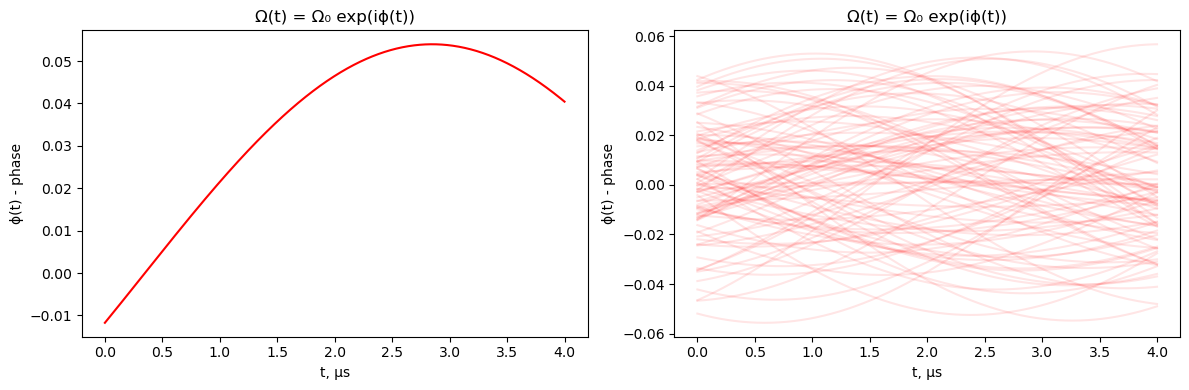

In [827]:
figure(figsize=(12, 4))
subplot(121)
plot(tspan, ϕ(tspan, 0.0, hg2, σg2 * (0.1/fg2)^2, 0.1), color="red");
xlabel("t, μs")
ylabel("ϕ(t) - phase")
title("Ω(t) = Ω₀ exp(iϕ(t))")


subplot(122)
for i ∈ [1:100;]
    plot(tspan, ϕ(tspan, 0.0, hg2, σg2 * (0.1/fg2)^2, 0.1), alpha=0.1, color="red");
end;
xlabel("t, μs")
ylabel("ϕ(t) - phase")
title("Ω(t) = Ω₀ exp(iϕ(t))")

tight_layout()

__Noise interpolation__

In [34]:
noise = ϕ(tspan, 1.0e-3, [], [], []);

plot(tspan, noise / (2*π), color="red");
xlabel("t, μs")
ylabel("ϕ(t)/2π - phase")
title("Ω(t) = Ω₀ exp(iϕ(t))")

nodes = (tspan, );
noise_intp = interpolate(nodes, noise, Gridded(Linear()));

In [45]:
figure(figsize=(10,4))
scatter(tspan, noise/(2.0*π), s=5, color="black", label="Траектория шума")
plot(tspan, noise_intp(tspan)/(2.0*π), color="red", linestyle="--", linewidth=2, label="Интерполяция")
title("Интерполяция шума", fontsize=fontsize)
xlim(0.0, maximum(tspan))
xlabel("t, мкс", fontsize=fontsize)
ylabel("ϕ(t)/2π", fontsize=fontsize)
legend(fontsize=fontsize-1)
tight_layout()
gcf()


savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/phase_interpolation.svg", dpi=200)
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/phase_interpolation.pdf", dpi=200)
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/phase_interpolation.png", dpi=200)

#### One-photon gate fidelity from white noise h0 with <span style="color:red">WRONG</span>  infidelity measure.

In [59]:
N = 2;
b = NLevelBasis(N);
g = nlevelstate(b, 1);
e = nlevelstate(b, 2);
Ω0 = 2*π;

# Basic operators
σge = Ω0/2 * g ⊗ dagger(e);
σeg = Ω0/2 * e ⊗ dagger(g);


h0 = 0.0;   #MHz^2/MHz
hg0 = 2.0e3 * 1e-6; #MHz^2/MHz
σg0 = 1.5 * 1e-3;   #MHz
fg0 = 234e-3;
sg0 = sqrt(8 * π) * σg0 * hg0 / fg0^2;
C = σg0 / fg0^2;


function one_photon_h0(tspan, h0, iters, N)
    Pg = zeros(length(tspan));
    Pe = zeros(length(tspan));
    Pg_realizations = [];
    Pe_realizations = [];
    
    ψ0 = nlevelstate(b, 1);
    ψ_mean = zero(ψ0);
    
    for i ∈ [1:iters;]
        # Noise realisation for red and blue laser
        noise = ϕ(tspan, h0, [], [], []);

        # Noise interpolation
        nodes = (tspan, );
        ϕ_intp = interpolate(nodes, noise, Gridded(Linear()));

        # Hamiltonian with particular noise realisation
        H_noisy = TimeDependentSum(
            [t->exp(im*ϕ_intp(t)),t->exp(-im*ϕ_intp(t))], 
            [σge, σeg]
                );
        tots, ψ = timeevolution.schroedinger_dynamic(tspan, ψ0, H_noisy);
        temp_Pg = expect(g ⊗ dagger(g), ψ);
        temp_Pe = expect(e ⊗ dagger(e), ψ);
        
        Pg += temp_Pg;
        Pe += temp_Pe;
        
        append!(Pg_realizations, [temp_Pg]);
        append!(Pe_realizations, [temp_Pe]);
        
        ψ_mean = ψ_mean .+ ψ[1+round(Int32, N*250)];
    end;
    Pg /= iters;
    Pe /= iters;
        
    ψ_mean /= iters
        
    return [ψ_mean, Pg, Pe, Pg_realizations, Pe_realizations]
end;
        
        
        
function onephoton_infidelity_white(h0, Ω0, N)
    return π^3 .* h0 .* N/Ω0
end;

In [584]:
maximum(real(Pe))

0.9901653189639084

In [585]:
maximum(real(expect(e⊗dagger(e), ψ_mean)))

0.9044524857221783

In [555]:
H0 = [0.1e-3:0.2e-3:4e-3;]

infidelity_π = [];
ρ_ideal = e ⊗ dagger(e);
for h ∈ H0
    ψ_mean, Pg, Pe, Pg_realizations, Pe_realizations = one_photon_h0(tspan, h, 200, 1/2);
    ρ_mean = ψ_mean ⊗ dagger(ψ_mean);
    append!(infidelity_π, 1 - real(fidelity(ρ_ideal, ρ_mean)));
end;

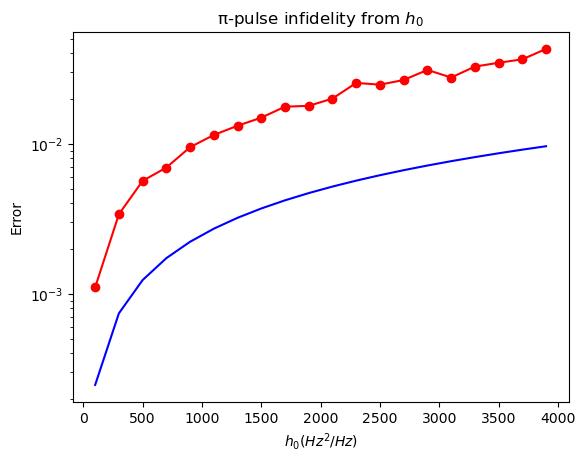

PyObject Text(0.5, 1.0, 'π-pulse infidelity from $h_0 $')

In [568]:
scatter(H0 * 1e6, infidelity_π,  color="red")
plot(H0 * 1e6, infidelity_π,  color="red")
plot(H0 * 1e6, onephoton_infidelity_white(H0, Ω0, 1/2), color="blue")

yscale("log");
# xlim(0.0, 4000)
# ylim(1e-4,1e-1)
xlabel("\$ h_0(Hz^2/Hz) \$")
ylabel("Error")
title("π-pulse infidelity from \$h_0 \$")

In [557]:
infidelity_2π = [];
ρ_ideal = g ⊗ dagger(g);
for h ∈ H0
    ψ_mean, Pg, Pe, Pg_realizations, Pe_realizations = one_photon_h0(tspan, h, 200, 1);
    ρ_mean = ψ_mean ⊗ dagger(ψ_mean);
    append!(infidelity_2π, 1 - real(fidelity(ρ_ideal, ρ_mean)));
end;

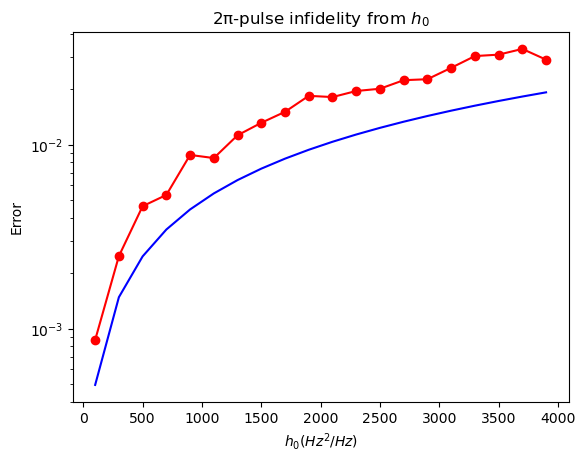

PyObject Text(0.5, 1.0, '2π-pulse infidelity from $h_0 $')

In [567]:
scatter(H0 * 1e6, infidelity_2π,  color="red")
plot(H0 * 1e6, infidelity_2π, color="red")
plot(H0 * 1e6, onephoton_infidelity_white(H0, Ω0, 1), color="blue")

yscale("log");
# xlim(0.0, 4000)
# ylim(1e-4,1e-1)
xlabel("\$ h_0(Hz^2/Hz) \$")
ylabel("Error")
title("2π-pulse infidelity from \$h_0 \$")

#### One-photon gate fidelity from white noise h0 with <span style="color:green">CORRECT</span>  infidelity measure.

In [829]:
N = 2;
b = NLevelBasis(N);
g = nlevelstate(b, 1);
e = nlevelstate(b, 2);
Ω0 = 2*π;

# Basic operators
σge = Ω0/2 * g ⊗ dagger(e);
σeg = Ω0/2 * e ⊗ dagger(g);


h0 = 0.0;   #MHz^2/MHz
hg0 = 2.0e3 * 1e-6; #MHz^2/MHz
σg0 = 1.5 * 1e-3;   #MHz
fg0 = 234e-3;
sg0 = sqrt(8 * π) * σg0 * hg0 / fg0^2;
C = σg0 / fg0^2;


function one_photon_h0(tspan, h0, iters, N)
    Pg = zeros(length(tspan));
    Pe = zeros(length(tspan));
    Pg_realizations = [];
    Pe_realizations = [];
    
    ψ0 = nlevelstate(b, 1);
    ρ_mean = zero(ψ0 ⊗ dagger(ψ0));
    
    for i ∈ [1:iters;]
        # Noise realisation for red and blue laser
        noise = ϕ(tspan, h0, [], [], []);

        # Noise interpolation
        nodes = (tspan, );
        ϕ_intp = interpolate(nodes, noise, Gridded(Linear()));

        # Hamiltonian with particular noise realisation
        H_noisy = TimeDependentSum(
            [t->exp(im*ϕ_intp(t)),t->exp(-im*ϕ_intp(t))], 
            [σge, σeg]
                );
        tots, ψ = timeevolution.schroedinger_dynamic(tspan, ψ0, H_noisy);
        temp_Pg = expect(g ⊗ dagger(g), ψ);
        temp_Pe = expect(e ⊗ dagger(e), ψ);
        
        Pg += temp_Pg;
        Pe += temp_Pe;
        
        append!(Pg_realizations, [temp_Pg]);
        append!(Pe_realizations, [temp_Pe]);
        
        ρ_mean = ρ_mean .+ ψ[1+round(Int32, N*250)] ⊗ dagger(ψ[1+round(Int32, N*250)]);
    end;
    Pg /= iters;
    Pe /= iters;
        
    ρ_mean /= iters
        
    return [ρ_mean, Pg, Pe, Pg_realizations, Pe_realizations]
end;
        
        
        
function onephoton_infidelity_white(h0, Ω0, N)
    return π^3 .* h0 .* N/Ω0
end;

In [830]:
H0 = [0.1e-3:0.05e-3:4e-3;]

infidelity_π = [];
ρ_ideal = e ⊗ dagger(e);
for h ∈ H0
    ρ_mean, Pg, Pe, Pg_realizations, Pe_realizations = one_photon_h0(tspan, h, 400, 1/2);
    append!(infidelity_π, 1 - real(fidelity(ρ_ideal, ρ_mean)));
end;

In [832]:
infidelity_2π = [];
ρ_ideal = g ⊗ dagger(g);
for h ∈ H0
    ρ_mean, Pg, Pe, Pg_realizations, Pe_realizations = one_photon_h0(tspan, h, 400, 1);
    append!(infidelity_2π, 1 - real(fidelity(ρ_ideal, ρ_mean)));
end;

#### One-photon gate fidelity from servobump <span style="color:green">without $1/f^2 \rightarrow 1/f^2_g$ assumption. </span> Fig.6

In [55]:
N = 2;
b = NLevelBasis(N);
g = nlevelstate(b, 1);
e = nlevelstate(b, 2);
Ω0 = 2*π;

# Basic operators
σge = Ω0/2 * g ⊗ dagger(e);
σeg = Ω0/2 * e ⊗ dagger(g);


h0 = 0.0;   #MHz^2/MHz
hg0 = 2.0e3 * 1e-6; #MHz^2/MHz
σg0 = 1.5 * 1e-3;   #MHz
fg0 = 234e-3;       #MHz
sg0 = sqrt(8 * π) * σg0 * hg0 / fg0^2;
C = σg0 / fg0^2;


function one_photon_fg(tspan, fg, iters, N)
    Pg = zeros(length(tspan));
    Pe = zeros(length(tspan));
    Pg_realizations = [];
    Pe_realizations = [];
    
    ψ0 = nlevelstate(b, 1);
    ρ_mean = zero(ψ0 ⊗ dagger(ψ0));
    
    for i ∈ [1:iters;]
        # Noise realisation for red and blue laser
        noise = ϕ(tspan, 0.0, [hg0], [C*fg^2], [fg]);

        # Noise interpolation
        nodes = (tspan, );
        ϕ_intp = interpolate(nodes, noise, Gridded(Linear()));

        # Hamiltonian with particular noise realisation
        H_noisy = TimeDependentSum(
            [t->exp(im*ϕ_intp(t)),t->exp(-im*ϕ_intp(t))], 
            [σge, σeg]
                );
        tots, ψ = timeevolution.schroedinger_dynamic(tspan, ψ0, H_noisy);
        temp_Pg = expect(g ⊗ dagger(g), ψ);
        temp_Pe = expect(e ⊗ dagger(e), ψ);
        
        Pg += temp_Pg;
        Pe += temp_Pe;
        
        append!(Pg_realizations, [temp_Pg]);
        append!(Pe_realizations, [temp_Pe]);
        
        ρ_mean = ρ_mean .+ ψ[1+round(Int32, N*250)] ⊗ dagger(ψ[1+round(Int32, N*250)]);
    end;
    Pg /= iters;
    Pe /= iters;
        
    ρ_mean /= iters
        
    return [ρ_mean, Pg, Pe, Pg_realizations, Pe_realizations]
end;
        
        
function onephoton_infidelity_bump(fg, Ω0, N)
    return 2 * sg0 * (π .* fg * Ω0) .^2 .* (1.0 .- (-1)^(2*N) * cos.(4*π^2*N .*fg / Ω0)) ./ (Ω0^2 .- 4*π^2 .* fg .^2).^2
end;

In [836]:
Fg = [0.1:0.05:4.3;]

infidelity_π_bump = [];
ρ_ideal = e ⊗ dagger(e);

for fg ∈ Fg
    ρ_mean, Pg, Pe, Pg_realizations, Pe_realizations = one_photon_fg(tspan, fg, 300, 1/2);
    append!(infidelity_π_bump, 1 - real(fidelity(ρ_ideal, ρ_mean)));
end;

In [838]:
Fg = [0.1:0.05:4.3;]

infidelity_2π_bump = [];
ρ_ideal = g ⊗ dagger(g);

for fg ∈ Fg
    ρ_mean, Pg, Pe, Pg_realizations, Pe_realizations = one_photon_fg(tspan, fg, 300, 1);
    append!(infidelity_2π_bump, 1 - real(fidelity(ρ_ideal, ρ_mean)));
end;

In [53]:

df_fg = DataFrame(CSV.File("../data/infidelity_fg.csv"));
df_h0 = DataFrame(CSV.File("../data/infidelity_h0.csv"));

Fg = df_fg."fg, MHz";
infidelity_π_bump = df_fg."Infidelity_Pi_Numerical";
infidelity_2π_bump = df_fg."Infidelity_2Pi_Numerical";

H0 = df_h0."h0, MHz^2/MHz";
infidelity_π = df_h0."Infidelity_Pi_Numerical";
infidelity_2π = df_h0."Infidelity_2Pi_Numerical";


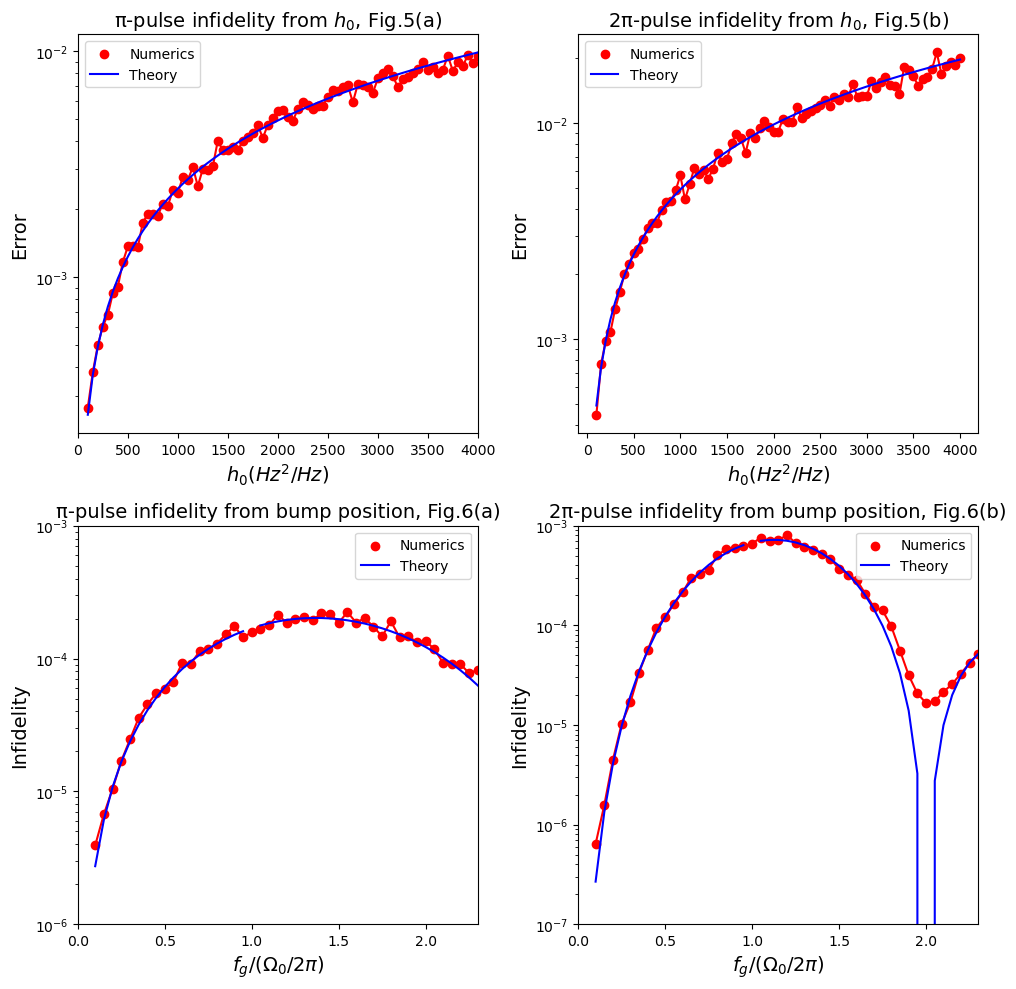

In [61]:
figure(figsize=(10, 10))
subplot(221)
scatter(H0 * 1e6, infidelity_π,  color="red", label="Numerics")
plot(H0 * 1e6, infidelity_π,  color="red")
plot(H0 * 1e6, onephoton_infidelity_white(H0, Ω0, 1/2), color="blue", label="Theory")

yscale("log");
xlim(0.0, 4000)
xlabel("\$ h_0(Hz^2/Hz) \$", fontsize=fontsize)
ylabel("Error", fontsize=fontsize)
title("π-pulse infidelity from \$h_0 \$, Fig.5(a)", fontsize=fontsize)
legend()


subplot(222)
scatter(H0 * 1e6, infidelity_2π,  color="red", label="Numerics")
plot(H0 * 1e6, infidelity_2π, color="red")
plot(H0 * 1e6, onephoton_infidelity_white(H0, Ω0, 1), color="blue", label="Theory")

yscale("log");
xlabel("\$ h_0(Hz^2/Hz) \$", fontsize=fontsize)
ylabel("Error", fontsize=fontsize)
title("2π-pulse infidelity from \$h_0 \$, Fig.5(b)", fontsize=fontsize)
legend()


subplot(223)
scatter(Fg, infidelity_π_bump, color="red", label="Numerics")
plot(Fg, infidelity_π_bump, color="red")
plot(Fg, onephoton_infidelity_bump(Fg, Ω0, 1/2), color="blue", label="Theory")
yscale("log");

xlim(0.0, 2.3)
ylim(1e-6, 1e-3)
xlabel("\$ f_g / (Ω_0 /2π)\$", fontsize=fontsize)
ylabel("Infidelity", fontsize=fontsize)
title("π-pulse infidelity from bump position, Fig.6(a)", fontsize=fontsize)
legend()


subplot(224)
scatter(Fg, infidelity_2π_bump, color="red", label="Numerics")
plot(Fg, infidelity_2π_bump, color="red")
plot(Fg, onephoton_infidelity_bump(Fg, Ω0, 1), color="blue", label="Theory")
yscale("log");

xlim(0.0, 2.3)
ylim(1e-7, 1e-3)
xlabel("\$ f_g / (Ω_0 /2π)\$", fontsize=fontsize)
ylabel("Infidelity", fontsize=fontsize)
title("2π-pulse infidelity from bump position, Fig.6(b)", fontsize=fontsize)
legend()


tight_layout()
gcf()


# savefig("data/tls_errors.pdf", dpi=300)

In [70]:
figure(figsize=(10, 10))
subplot(221)
scatter(H0 * 1e6, infidelity_π,  color="red", label="Моделирование")
plot(H0 * 1e6, infidelity_π,  color="red")
plot(H0 * 1e6, onephoton_infidelity_white(H0, Ω0, 1/2), color="blue", label="Теория")

yscale("log");
xlim(0.0, 4000)
xlabel("\$ h_0, \\text{Гц}^2/ \\text{Гц} \$", fontsize=fontsize)
ylabel("Ошибка", fontsize=fontsize)
title("Ошибка π-импульса от \$h_0 \$, Fig.5(a)", fontsize=fontsize)
legend()


subplot(222)
scatter(H0 * 1e6, infidelity_2π,  color="red", label="Моделирование")
plot(H0 * 1e6, infidelity_2π, color="red")
plot(H0 * 1e6, onephoton_infidelity_white(H0, Ω0, 1), color="blue", label="Теория")

yscale("log");
xlabel("\$ h_0, \\text{Гц}^2 / \\text{Гц} \$", fontsize=fontsize)
ylabel("Ошибка", fontsize=fontsize)
title("Ошибка 2π-импульса от \$h_0 \$, Fig.5(b)", fontsize=fontsize)
legend()


subplot(223)
scatter(Fg, infidelity_π_bump, color="red", label="Моделирование")
plot(Fg, infidelity_π_bump, color="red")
plot(Fg, onephoton_infidelity_bump(Fg, Ω0, 1/2), color="blue", label="Теория")
yscale("log");

xlim(0.0, 2.3)
ylim(1e-6, 1e-3)
xlabel("\$ f_g / (Ω_0 /2π)\$", fontsize=fontsize)
ylabel("Ошибка", fontsize=fontsize)
title("Ошибка π-импульса от \$f_g\$, Fig.6(a)", fontsize=fontsize)
legend()


subplot(224)
scatter(Fg, infidelity_2π_bump, color="red", label="Моделирование")
plot(Fg, infidelity_2π_bump, color="red")
plot(Fg, onephoton_infidelity_bump(Fg, Ω0, 1), color="blue", label="Теория")
yscale("log");

xlim(0.0, 2.3)
ylim(1e-7, 1e-3)
xlabel("\$ f_g / (Ω_0 /2π)\$", fontsize=fontsize)
ylabel("Ошибка", fontsize=fontsize)
title("Ошибка 2π-импульса от \$f_g\$, Fig.6(b)", fontsize=fontsize)
legend()


tight_layout()
gcf()


# savefig("data/tls_errors.pdf", dpi=300)
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/noise_errors.svg", dpi=300)
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/noise_errors.pdf", dpi=300)
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/noise_errors.png", dpi=300)

In [12]:
# data_h0 = DataFrame(
#     "h0, MHz^2/MHz" => H0, 
#     "Infidelity_Pi_Numerical" => infidelity_π, 
#     "Infidelity_Pi_Theory" => onephoton_infidelity_white(H0, Ω0, 1/2), 
#     "Infidelity_2Pi_Numerical" => infidelity_2π,
#     "Infidelity_2Pi_Theory" => onephoton_infidelity_white(H0, Ω0, 1)
    
# );
# data_fg = DataFrame(
#     "fg, MHz" => Fg, 
#     "Infidelity_Pi_Numerical" => infidelity_π_bump, 
#     "Infidelity_Pi_Theory" => onephoton_infidelity_bump(Fg, Ω0, 1/2), 
#     "Infidelity_2Pi_Numerical" => infidelity_2π_bump,
#     "Infidelity_2Pi_Theory" => onephoton_infidelity_bump(Fg, Ω0, 1)
# );

#I shoud find later how to include metadata in CSV
# metadata!(data_h0, "description", "Two-level system Pi&2Pi-pulse infidelity from white noise amplitude. System is driven resonantly, no servo-bumps.");
# metadata!(data_fg, "description", "Two-level system Pi&2Pi-pulse infidelity from servo-bump central frequency. System is driven resonantly, no white noise.");
# metadata!(data_fg, "params", "sigma_g0 = 1.5kHz, hg0 = 0.002 MHz^2/MHz, fg0=234kHz");

# CSV.write("data/infidelity_h0.csv", data_h0);
# CSV.write("data/infidelity_fg.csv", data_fg);

In [14]:
data_fg = DataFrames(CSV.read("data/infidelity_fg.csv"))

LoadError: ArgumentError: provide a valid sink argument, like `using DataFrames; CSV.read(source, DataFrame)`

### Two-photon gate fidelity from white noise h0. Fig.9

### <span style="color: red"> Вопросы?</span>

- Почему на графиках 5 и 6 теоретическая кривая доходит до 10^-7, а не уходит в -бесконечность? Там ведь 0 должен быть. Выглядит как подгон.


- Почему такие большие погрешности - порядок? Как сделана оценка погрешностей?


- Зачем писать, что результаты могут отличаться от общепринятых на множитель 2? Звучит как "мы уверены, что оно точно отличается, но где мы двойку про***бали мы не уверены"


- Сервобамп на очень низкой частоте с большой амплитудой это, вообще говоря, беда. Возможно, чуваки просто нижнюю обрезку по частотам делают так, что кусок бампа просто отрезается при моделировании.

### Time-dependent hamiltonian

__Hamiltonian__

$H = -\Delta \left|1\right>\left<1\right| - \delta \left|2\right>\left<2\right| + \frac{\Omega_r(t)}{2}\left(e^{i \phi_r(t)}\left|0\right>\left<1\right|+e^{-i \phi_r(t)}\left|1\right>\left<0\right| \right) + \frac{\Omega_b(t)}{2}\left(e^{i \phi_b(t)}\left|1\right>\left<2\right|+e^{-i \phi_b(t)}\left|2\right>\left<1\right| \right)$

- $\phi_r(t), \phi_b(t)$ - phase noise from red and blue laser


- $\Omega_r(t), \Omega_b(t)$ can include amplitude noise + atom dynamics


__Lindblad part__


...




__Correspondence with Julia code:__


- $\left| g\right> = \left| 1 \right>$

- $\left| p\right> = \left| 2 \right>$

- $\left| r\right> = \left| 3 \right>$

- $\left| g'\right> = \left| 4 \right>$

In [70]:
# Experimental params
Ωb = 2π * 47;
Ωr = 2π * 47;
Δ = 2π * 900;
δ = (Ωb^2 - Ωr^2)/(4*Δ);
Γ = 2π * 6;
Γg = 1/4 * Γ;
Γg_trash = 3/4 * Γ;

In [9]:
# Basis and states
N = 4
b = NLevelBasis(N);
g = nlevelstate(b, 1);
p = nlevelstate(b, 2);
r = nlevelstate(b, 3);
g_trash = nlevelstate(b, 4);


# Damping operators for Lindblad
Jg = sqrt(Γg)* g ⊗ dagger(p);
Jg_trash = sqrt(Γg_trash)* g_trash ⊗ dagger(p);
J = [Jg, Jg_trash];
Jdagger = [dagger(Jg), dagger(Jg_trash)];


# Basic operators
σgp = Ωr/2 * g ⊗ dagger(p);
σpr = Ωb/2 * p ⊗ dagger(r);
σgp_d = dagger(Ωr/2 * g ⊗ dagger(p));
σpr_d = dagger(Ωb/2 * p ⊗ dagger(r));

# Static part that accounts for level shifts
H_static = - Δ * p ⊗ dagger(p) - δ * r ⊗ dagger(r);

In [11]:
#Saffman laser noise params
h0 = 13.0 * 1e-6;   #MHz^2/MHz
hg1 = 25.0 * 1e-6;  #MHz^2/MHz
hg2 = 2.0e3 * 1e-6; #MHz^2/MHz
fg1 = 130.0 * 1e-3; #MHz
fg2 = 234.0 * 1e-3; #MHz
σg1 = 18.0 * 1e-3;  #MHz
σg2 = 1.5 * 1e-3;   #MHz

hg = [hg1, hg2];
σg = [σg1, σg2];
fg = [fg1, fg2];


# Finite contrast
eps, eps_tick, eta = 0.05, 0.08, 0.03;

In [12]:
function rydberg_simulation(tspan, h0, hg, σg, fg, iters)
    Pg = zeros(length(tspan));
    Pr = zeros(length(tspan));
    Pg_realizations = [];
    Pr_realizations = [];
    
    ψ0 = nlevelstate(b, 1);
    ρ0 = ψ0 ⊗ dagger(ψ0);
    
    
    for i ∈ [1:iters;]
        # Noise realisation for red and blue laser
        noise_r = ϕ(tspan, h0, hg, σg, fg);
        noise_b = ϕ(tspan, h0, hg, σg, fg);


        # Noise interpolation
        nodes = (tspan, );
        ϕ_r = interpolate(nodes, noise_r, Gridded(Linear()));
        ϕ_b = interpolate(nodes, noise_b, Gridded(Linear()));


        # Hamiltonian with particular noise realisation
        H_noisy = TimeDependentSum(
            [1.0, t->exp(im*ϕ_r(t)),t->exp(-im*ϕ_r(t)), t->exp(im*ϕ_b(t)), t->exp(-im*ϕ_b(t))], 
            [H_static, σgp, σgp_d, σpr, σpr_d]
                );
        tots, ρ = timeevolution.master_dynamic(tspan, ρ0, H_noisy, J);
        temp_Pg = expect(g ⊗ dagger(g), ρ);
        temp_Pr = expect(r ⊗ dagger(r), ρ);
        
        Pg += temp_Pg;
        Pr += temp_Pr;
        
        append!(Pg_realizations, [temp_Pg]);
        append!(Pr_realizations, [temp_Pr]);
    end;
    Pg /= iters;
    Pr /= iters;
        
    return [Pg, Pr, Pg_realizations, Pr_realizations]
end;

In [345]:
Pg, Pr, Pg_realizations, Pr_realizations = rydberg_simulation(tspan, h0, hg, σg, fg, 500);

In [346]:
ψ0 = nlevelstate(b, 1);
ρ0 = ψ0 ⊗ dagger(ψ0);

tots, ρ = timeevolution.master(tspan, ρ0, H, J; alg=Rosenbrock23(autodiff=false));

Pg_clear = expect(g ⊗ dagger(g), ρ);
Pr_clear = expect(r ⊗ dagger(r), ρ);

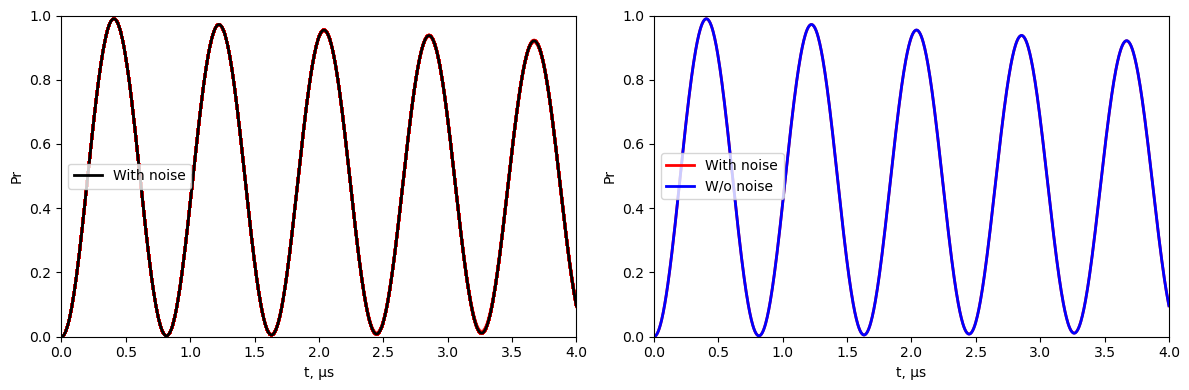

In [347]:
figure(figsize=(12,4))
    
subplot(121)
for temp_Pr ∈ Pr_realizations
    plot(tspan, temp_Pr, linewidth=2, color="red", alpha=0.05)
end;

plot(tspan, Pr, linewidth=2, color="black", label="With noise")

xlabel("t, μs")
ylabel("Pr")
ylim(0.0, 1.0)
xlim(0.0, 4.0)
legend()


subplot(122)
plot(tspan, Pr, linewidth=2, color="red", label="With noise")
plot(tspan, Pr_clear, linewidth=2, color="blue", label="W/o noise")
xlabel("t, μs")
ylabel("Pr")
ylim(0.0, 1.0)
xlim(0.0, 4.0)
legend()

tight_layout()

#### $\pi$-pulse fidelity from $f_g$ - peak frequency of servo-bump

In [136]:
T = 1.0;
M = floor(Int, 1e3);
dt = T/M;
tspan = [0.0:dt:T;];

F = 10.0
Δf = F/M;
f = [0.0:Δf:10.0;];


function rydberg_simulation(tspan, h0, hg, σg, fg, iters;)
    Pg = zeros(length(tspan));
    Pr = zeros(length(tspan));
    Pg_realizations = [];
    Pr_realizations = [];
    
    ψ0 = nlevelstate(b, 1);
    ρ0 = ψ0 ⊗ dagger(ψ0);
    ρ_mean = zero(ρ0);
    
    
    for i ∈ [1:iters;]
        # Noise realisation for red and blue laser
        noise_r = ϕ(tspan, h0, hg, σg, fg);
        noise_b = ϕ(tspan, h0, hg, σg, fg);


        # Noise interpolation
        nodes = (tspan, );
        ϕ_r = interpolate(nodes, noise_r, Gridded(Linear()));
        ϕ_b = interpolate(nodes, noise_b, Gridded(Linear()));


        # Hamiltonian with particular noise realisation
        H_noisy = TimeDependentSum(
            [1.0, t->exp(im*ϕ_r(t)),t->exp(-im*ϕ_r(t)), t->exp(im*ϕ_b(t)), t->exp(-im*ϕ_b(t))], 
            [H_static, σgp, σgp_d, σpr, σpr_d]
                );
        tots, ρ = timeevolution.master_dynamic(tspan, ρ0, H_noisy, J);
        temp_Pg = expect(g ⊗ dagger(g), ρ);
        temp_Pr = expect(r ⊗ dagger(r), ρ);
        
        Pg += temp_Pg;
        Pr += temp_Pr;
        
        append!(Pg_realizations, [temp_Pg]);
        append!(Pr_realizations, [temp_Pr]);
        
        idx = argmax(real(expect(r ⊗ dagger(r), ρ)));
        ρ_mean = ρ_mean .+ ρ[idx]
    end;
    Pg /= iters;
    Pr /= iters;
        
    ρ_mean /= iters
        
    return [ρ_mean, Pg, Pr, Pg_realizations, Pr_realizations]
end;

In [147]:
#Saffman laser noise params
h0 = 13.0 * 1e-6;   #MHz^2/MHz
hg = 2.0e3 * 1e-6; #MHz^2/MHz
σg = 1.5 * 1e-3;   #MHz

Fg = [0.1:0.1:2.4;]

infidelity = [];
ρ_ideal = nlevelstate(b, 3) ⊗ dagger(nlevelstate(b, 3));

for fg ∈ Fg
    ρ_mean, Pg, Pr, Pg_realizations, Pr_realizations = rydberg_simulation(tspan, h0, hg, σg, fg, 200);
    append!(infidelity, 1 - real(fidelity(ρ_ideal, ρ_mean)));
end;

In [154]:
ψ0 = nlevelstate(b, 1);
ρ0 = ψ0 ⊗ dagger(ψ0);

tots, ρ = timeevolution.master(tspan, ρ0, H, J; alg=Rosenbrock23(autodiff=false));

Pg_clear = expect(g ⊗ dagger(g), ρ);
Pr_clear = expect(r ⊗ dagger(r), ρ);

In [167]:
function rydberg_simulation(tspan, h0, hg, σg, fg, iters;)
    Pg = zeros(length(tspan));
    Pr = zeros(length(tspan));
    Pg_realizations = [];
    Pr_realizations = [];
    
    ψ0 = nlevelstate(b, 1);
    ρ0 = ψ0 ⊗ dagger(ψ0);
    ρ_mean = zero(ρ0);
    
    
    for i ∈ [1:iters;]
        # Noise realisation for red and blue laser
        noise_r = ϕ(tspan, h0, hg, σg, fg);
        noise_b = ϕ(tspan, h0, hg, σg, fg);


        # Noise interpolation
        nodes = (tspan, );
        ϕ_r = interpolate(nodes, noise_r, Gridded(Linear()));
        ϕ_b = interpolate(nodes, noise_b, Gridded(Linear()));


        # Hamiltonian with particular noise realisation
        H_noisy = TimeDependentSum(
            [1.0, t->exp(im*ϕ_r(t)),t->exp(-im*ϕ_r(t)), t->exp(im*ϕ_b(t)), t->exp(-im*ϕ_b(t))], 
            [H_static, σgp, σgp_d, σpr, σpr_d]
                );
        tots, ρ = timeevolution.master_dynamic(tspan, ρ0, H_noisy, J);
        temp_Pg = expect(g ⊗ dagger(g), ρ);
        temp_Pr = expect(r ⊗ dagger(r), ρ);
        
        Pg += temp_Pg;
        Pr += temp_Pr;
        
        append!(Pg_realizations, [temp_Pg]);
        append!(Pr_realizations, [temp_Pr]);
        
        ρ_mean = ρ_mean .+ ρ[idx]
    end;
    Pg /= iters;
    Pr /= iters;
        
    ρ_mean /= iters
        
    return [ρ_mean, Pg, Pr, Pg_realizations, Pr_realizations]
end;

In [107]:
#Saffman laser noise params
h0 = 13.0 * 1e-6;   #MHz^2/MHz
hg = 2.0e3 * 1e-6; #MHz^2/MHz
σg = 1.5 * 1e-3;   #MHz

Fg = [0.1:0.1:2.4;]

infidelity = [];
ρ_ideal = nlevelstate(b, 3) ⊗ dagger(nlevelstate(b, 3));

for fg ∈ Fg
    ρ_mean, Pg, Pr, Pg_realizations, Pr_realizations = rydberg_simulation(tspan, h0, hg, σg, fg, 200);
    append!(infidelity, 1 - real(fidelity(ρ_ideal, ρ_mean)));
end;

LoadError: BoundsError: attempt to access 29-codeunit String

In [170]:
function rydberg_simulation_no_spontaneous(tspan, h0, hg, σg, fg, iters;)
    Pg = zeros(length(tspan));
    Pr = zeros(length(tspan));
    Pg_realizations = [];
    Pr_realizations = [];
    
    ψ0 = nlevelstate(b, 1);
    ρ0 = ψ0 ⊗ dagger(ψ0);
    ρ_mean = zero(ρ0);
    
    
    for i ∈ [1:iters;]
        # Noise realisation for red and blue laser
        noise_r = ϕ(tspan, h0, hg, σg, fg);
        noise_b = ϕ(tspan, h0, hg, σg, fg);


        # Noise interpolation
        nodes = (tspan, );
        ϕ_r = interpolate(nodes, noise_r, Gridded(Linear()));
        ϕ_b = interpolate(nodes, noise_b, Gridded(Linear()));


        # Hamiltonian with particular noise realisation
        H_noisy = TimeDependentSum(
            [1.0, t->exp(im*ϕ_r(t)),t->exp(-im*ϕ_r(t)), t->exp(im*ϕ_b(t)), t->exp(-im*ϕ_b(t))], 
            [H_static, σgp, σgp_d, σpr, σpr_d]
                );
        tots, ρ = timeevolution.master_dynamic(tspan, ρ0, H_noisy, []);
        temp_Pg = expect(g ⊗ dagger(g), ρ);
        temp_Pr = expect(r ⊗ dagger(r), ρ);
        
        Pg += temp_Pg;
        Pr += temp_Pr;
        
        append!(Pg_realizations, [temp_Pg]);
        append!(Pr_realizations, [temp_Pr]);
        
        ρ_mean = ρ_mean .+ ρ[π_idx]
    end;
    Pg /= iters;
    Pr /= iters;
        
    ρ_mean /= iters
        
    return [ρ_mean, Pg, Pr, Pg_realizations, Pr_realizations]
end;

In [248]:
function onephoton_infidelity_bump(fg, hg0, σg0, fg0, Ω0, sg0, N)
    σg = C .* fg .^2;
    return 2.0 .* sg0 .* (π .* fg .* Ω0).^2 .* (1 .- (-1) .^ (2 .* N) .* cos.(4 .* π^2 .* N .* fg/Ω0)) ./(Ω0^2 .- 4 .* π^2 .* fg .^2) .^2
end;

# function onephoton_infidelity_tilde(hg, σg, fg, Ω0, N)
#     sg = sqrt(8*π) .* σg .* hg ./ fg .^2 
#     return 4 * π^2 * sg .* fg .^2 .* (Ω0^2 .+ 4*π^2 .* fg .^ 2) .* (1 .- (-1)^(2*N) .* cos.(4 * π^2 * N .* fg / Ω0)) ./ (Ω0^2 .- 4*π^2 .* fg .^2).^2
# end;

## 4-level system + noise

- laser amplitude and phase noise

- atom dynamics 

$H = -\Delta \left|1\right>\left<1\right| + \frac{\Omega_r(t)}{2}\left(e^{i \phi_r(t)}\left|0\right>\left<1\right|+e^{-i \phi_r(t)}\left|1\right>\left<0\right| \right) + \frac{\Omega_b(t)}{2}\left(e^{i \phi_b(t)}\left|1\right>\left<2\right|+e^{-i \phi_b(t)}\left|2\right>\left<1\right| \right)$

- $\phi_r(t), \phi_b(t)$ - phase noise from red and blue laser


- $\Omega_r(t), \Omega_b(t)$ can include amplitude noise + atom dynamics



Master equation is slightly modified in a way that hamiltonian becomes time-dependent on amplitude, phase and dynamics noises, so we solve stochastic master equation.


For now suppose $\Omega_r, \Omega_b$ are constant, so we account only for phase noise. 